<a href="https://colab.research.google.com/github/IrisFDTD/AI-UNIZAR-course/blob/main/eot/ai_unizar_course_scattering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">*Introducción a la inteligencia artificial: redes neuronales avanzadas con Tensorflow-Keras*</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Sergio Gutiérrez Rodrigo (sergut@unizar.es)</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Licencia Creative Commons Atribución-NoComercial-CompartirIgual 4.0 Internacional</a>.

```
Sergio G Rodrigo
Departamento de Física Aplicada
Universidad de Zaragoza
Instituto de Nanociencia y Materiales de Aragón (INMA)
C/ Pedro Cerbuna, 12, 50009, Zaragoza, España
```






# **Advanced Neural Networks with TensorFlow-Keras**

---
# **Replace numerical methods with neural networks: direct model: numerical method surrogate**
---


#*Extraordinary Optical Transmission (EOT)*

The phenomenom of **Extraordinary optical transmission (EOT)** is a family of EM resonances through subwavelength apertures, in either a flat or a corrugated metallic film [1]. These resonances provide high transmission of light, much more that would be expected for such tiny apertures as compared to the wavelength of light [2]. EOT was discovered in 1998 and since then it has been a very active research field, leading both to the discovery of new ways of enhancing the optical transmission and to its application to sensing, color filters, metamaterials, lenses, optical trapping, enhancement of nonlinear effects, among others [3].

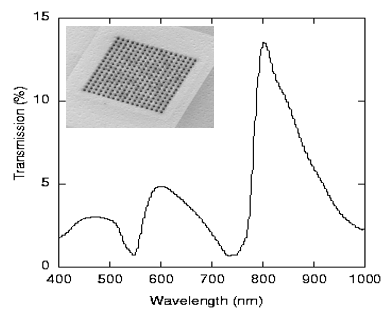

One of the methods to  to calculate the optical response in these system is the so-called **Modal Expansion (ME)**. The ME method (on which the calculations of this notebook are based) Maxwells equations are solved by expanding the electromagnetic (EM) fields in the different regions of space, transmission and reflection coefficients are thus calculated by imposing appropriate boundary conditions (see Ref. [4], and references therein). The whole space is divided in three regions: (I) the cover, (II) holes and, (III) the substrate. In regions (I) and (III) the EM fields are expanded in planes waves. In region (II) in terms of TE and TM waveguide eigenmodes. However, good convergence is attained in many situations only by considering the less decaying transversal electric mode. Within this minimal model results can be worked out analytically.  

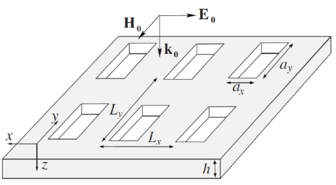

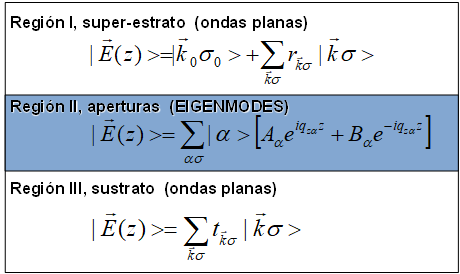




 *References:*

[1] T. W. Ebbesen, H. L. Lezec, H. F. Ghaemi, T. Thio, and P. A. Wolff, [*Extraordinary optical transmission through subwavelength
hole arrays*](https://www.nature.com/articles/35570), Nature 391, 667–669 (1998).

[2] H. A. Bethe, [*Theory of difraction by small holes*](https://journals.aps.org/pr/abstract/10.1103/PhysRev.66.163), Phys. Rev. 66, 163–182 (1944).


[3] S.G. Rodrigo, F. de León-Pérez, and L. Martín-Moreno, [*Extraordinary Optical Transmission: fundamentals and applications*](https://ieeexplore.ieee.org/document/7592449), Proceedings of the IEEE 104, 2288 (2016).

[4] F.J. Garcia-Vidal, L. Martin-Moreno, T.W. Ebbesen, L. Kuipers, [*Light passing through subwavelength apertures*](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.82.729), Rev. Mod. Phys. 82, 729–787 (2010).

[5] S.G. Rodrigo [*Terahertz gas sensor based on absorption-induced transparency (appendix)*](https://epjam.edp-open.org/articles/epjam/pdf/2016/01/epjam160014.pdf) EPJ Appl. Metamat. 3,11 (2016).

# Mount Google Drive (local uploading)

In [ ]:
#Your google drive is made accesible to Colab.
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd /content/drive/MyDrive/docencia_2023-2024/curso_IA_2023-2024/AI-UNIZAR-course-github/eot/
    %ls -lht
    # To import own packages set local path in packages syspath
    import sys
    sys.path.insert(0,"./")
except ImportError:
    print("You are not in google.colab!!")
    pass

# Clone from Github (remote uploading)

In [ ]:
# Install Git (if not already installed)
!apt-get -q install git

# Replace placeholders with actual values
username = "IrisFDTD"
repository = "AI-UNIZAR-course"

# Clone the repository
repo_url = f"https://@github.com/{username}/{repository}.git"
!git clone {repo_url}

%cd {repository}
%cd ./eot/
%ls -lht

# Main imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import models,layers,utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import SGD, Adam

# Auxiliary functions

In [3]:
def plot_history(history):
    train_loss = history.history['loss']
    epochs = range(1, len(train_loss) + 1)

    # Extract the validation loss values
    val_loss = history.history['val_loss']

    # Plot the training loss and validation loss vs. epoch
    plt.rcParams.update({'font.size': 14})
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    pass

# Geometrical and material parameters

Material: Perfect Electric Conductor (PEC)

Structure: periodic array of square holes drilled in a PEC film surrounded by air ($\varepsilon_{cover}=\varepsilon_{substrate}=1$)

Calculations with ME: transmittance and reflectance in the visible and near-infrrared range.

Geometrical parameters:
+ $h \in [80nm,400nm], \Delta h=[h]/15$
+ $L \in [400nm,700nm], \Delta L=[L]/15$
+ $a \in [100nm,0.8L], \Delta a=[a]/15$

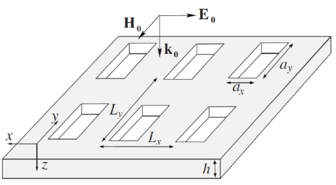

# Load data

+  Each spectrum is calculated at 300 wavelengths from 400.0 nm to 1000.0 nm
+  The database contains 3375 spectra.
+ Data structure: [Metal thickness $h$]; [period $L=L_x=L_y$]; [hole size $a=a_x=a_y$]; [reflection $R$]; [transmission $T$]

In [4]:
# Relative path of the dataset
pathSCATT = "./PEC_NN_300x15x15x15.xlsx"

# Spectra resolution (number of wavelengths)
nwav=300

# Select a reduced number of spectra for training
nospectra_training=100
SCATT = pd.read_excel(pathSCATT,nrows=nospectra_training*nwav)

# Print scattering dataset
SCATT

,width0,L0,a0,lambda0,R,T
0,80.001,400.000100,100.001000,400.001000,1.000000,8.739156e-10
1,80.001,400.000100,100.001000,402.007689,0.997346,2.654320e-03
2,80.001,400.000100,100.001000,404.014378,0.999078,9.220236e-04
3,80.001,400.000100,100.001000,406.021067,0.999383,6.172217e-04
4,80.001,400.000100,100.001000,408.027756,0.999510,4.898476e-04
...,...,...,...,...,...,...
29995,80.001,528.571914,307.551627,991.974244,0.604943,3.950570e-01
29996,80.001,528.571914,307.551627,993.980933,0.608119,3.918814e-01
29997,80.001,528.571914,307.551627,995.987622,0.611260,3.887401e-01
29998,80.001,528.571914,307.551627,997.994311,0.614367,3.856328e-01


# Normalize

In [5]:
# Geometric parameters normalized with respect to the maximum wavelength of light
SCATTnorm = SCATT.copy()
max_lambda = SCATT.iloc[:, 3].max()
SCATTnorm.iloc[:, :4] = SCATT.iloc[:, :4] / max_lambda

#Set the training and validation data

In [6]:
# Set training and test data from the normalized dataset
# Function train_test_split() split & randomize data
train_data, test_data = train_test_split(SCATTnorm, test_size=0.1, random_state=42) #sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

# Select input and output data for the neural network
x_train = train_data.iloc[:, :4]  # get the first 4 columns
y_train = train_data.iloc[:, -1]  # get one of the last 2 column for scattering

x_val = test_data.iloc[:, :4]  # get the first 4 columns
y_val = test_data.iloc[:, -1]  # get one of the last 2 column for scattering

print(x_train.head())
print(y_train.head())

# From pandas to numpy arrays
x_train=np.array(x_train)
x_val=np.array(x_val)

         width0        L0        a0   lambda0
346    0.080001  0.400000  0.115715  0.492308
13028  0.080001  0.442857  0.336122  0.656857
8821   0.080001  0.421428  0.337143  0.642810
25676  0.080001  0.507143  0.318368  0.753178
7534   0.080001  0.421428  0.269388  0.468228
346      0.000655
13028    0.999980
8821     0.998211
25676    0.984876
7534     0.601670
Name: T, dtype: float64


# Define and run the neural network (sequential model)

In [ ]:
network_name='./model_1.keras'

In [ ]:
#hiperparameters
epochs  =		1000
mini_batch_size= 64

In [ ]:
input_neurons=x_train.shape[1] # One neuron for each input parameter
output_neurons=1 # One neuron for value to predict

model=tf.keras.models.Sequential()
model.add(layers.Dense(80, activation='sigmoid', input_shape=(input_neurons,)))
model.add(layers.Dense(80, activation='sigmoid'))
model.add(layers.Dense(output_neurons, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                400       
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 1)                 81        
                                                                 
Total params: 6961 (27.19 KB)
Trainable params: 6961 (27.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optimizer = Adam()
model.compile(optimizer=optimizer,loss='mse',metrics=['mse'])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=mini_batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val))
model.save(network_name)
plot_history(history)

## Results: neural network prediction against true values

./model_1.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                400       
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 1)                 81        
                                                                 
Total params: 6961 (27.19 KB)
Trainable params: 6961 (27.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
4/4 [==============================] - 0s 3ms/step


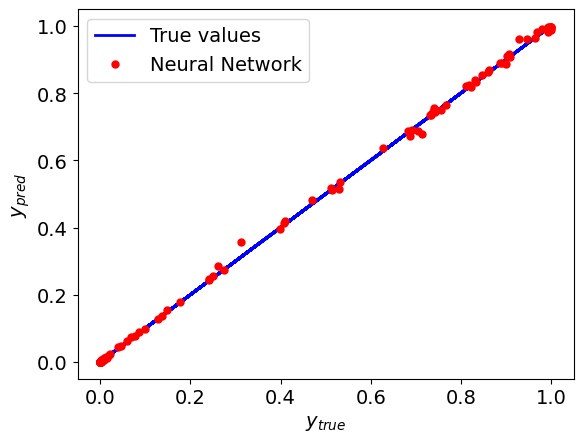

In [ ]:
model=models.load_model(network_name)
print(network_name)
model.summary()
score = model.evaluate(x_val, y_val, verbose=1)

# Check validation dataset with N random values
N=100
range_rnd=np.random.randint(0,len(x_val),size=(1,N))
y_pred=model.predict(x_val[range_rnd[0]])
y_true=y_val.iloc[range_rnd[0]]

# Plot true vs predicted
plt.plot(y_true,y_true, color="blue", fillstyle='none',linewidth=2, marker='.', markersize=0,label='True values')
plt.plot(y_true,y_pred, color="red", linewidth=0, marker='.', markersize=10,label='Neural Network')
plt.xlabel('$y_{true}$')
plt.ylabel('$y_{pred}$')
plt.legend()
plt.show()

## Visualize spectra: neural network prediction against true values

./model_1.keras
index: 19
10/10 [==============================] - 0s 2ms/step
Parameters =
 [[ 80.001      442.85737143 263.46986245 400.001     ]]


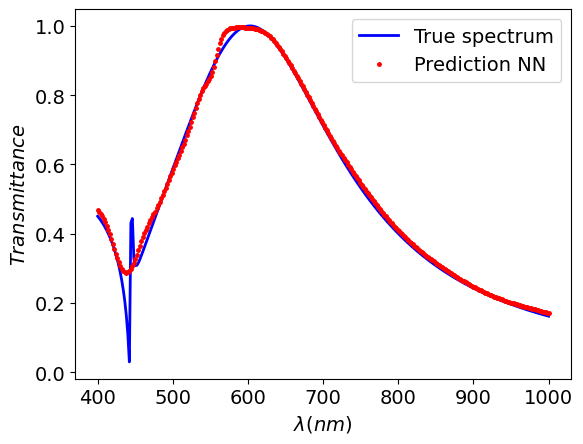

In [ ]:
model=models.load_model(network_name)
print(network_name)

# Number of wavelengths for spectrum
nwav=300

# Use test_data from normalized dataset
train_data, test_data = train_test_split(SCATTnorm, test_size=0.8, shuffle = False)

# Convert to numpy arrays
train_data=np.array(train_data)
test_data=np.array(test_data)

# Test data
x_test = test_data[:, :4]  # get the first 4 columns
y_test = test_data[:, -1] # get one of the last 2 column for scattering

# Random picked spectrum in test
j=np.random.randint(int(x_test.shape[0]/300)) #j-esima wavelength
print('index:',j)

# Wavelengths
wavelengths=x_test[j*nwav:(j+1)*nwav,3]

# Neural Network prediction
nn_pred=model.predict([x_test[j*nwav:(j+1)*nwav]])

# Print the geometrical parameters (normalized)
max_lambda = SCATT.iloc[:, 3].max()
wavelengths=wavelengths*max_lambda
parameters=max_lambda*x_test[j*nwav:(j+1)*nwav, :]
print("Parameters =\n",parameters[0:1])

# Scattering
scatt_true=y_test[j*nwav:(j+1)*nwav]
scatt_pred=nn_pred

# Plot
plt.plot(wavelengths,scatt_true, color="blue", fillstyle='none',linewidth=2, marker='.', markersize=0,label='True spectrum')
plt.plot(wavelengths,scatt_pred, color="red", linewidth=0, marker='.', markersize=5,label='Prediction NN')
plt.xlabel('$\lambda (nm)$')
plt.ylabel('$Transmittance$')
plt.legend()
plt.show()

# Define and run the neural network (multi-input model)

In [7]:
network_name_multiinput='./model_2.keras'

In [8]:
#hiperparameters
epochs  =		1000
mini_batch_size= 64

In [9]:
# Input 1: geometrical parameters
input_geo=Input((3,))
x_geo=Dense(80, activation='sigmoid')(input_geo)
x_geo=Dense(80, activation='sigmoid')(x_geo)

# Input 2: wavelengtth
input_lambda=Input((1,))
x_lambda=Dense(20, activation='sigmoid')(input_lambda)

# Concatenate inputs
x=tf.keras.layers.concatenate([x_geo,x_lambda])

# Last layer(s) and output
x=Dense(10, activation='sigmoid')(x)
output=Dense(1,activation='sigmoid')(x)

# Create the model
model=tf.keras.Model([input_geo,input_lambda],output)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 80)                   320       ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 80)                   6480      ['dense[0][0]']               
                                                                                              

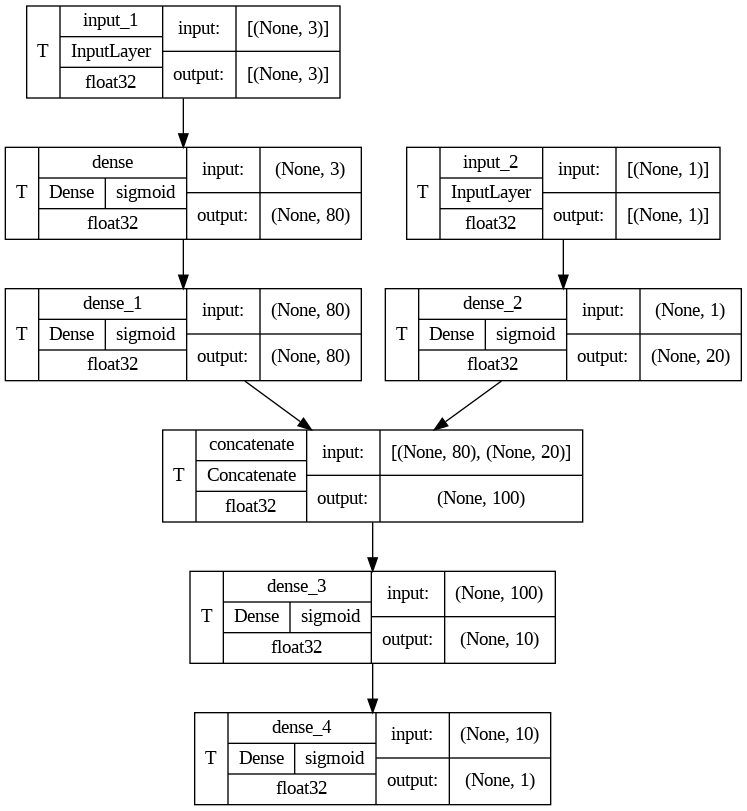

In [10]:
from IPython.display import display

model.summary()

# Plot a schematics of the model
img=utils.plot_model(model,
                     to_file=network_name_multiinput+'.png',
                     show_shapes=True,
                     show_dtype=True,
                     show_layer_names=True,
                     rankdir='TB', #'TB' = vertical plot; 'LR' = horizontal plot.
                     expand_nested=True,
                     dpi=96,
                     show_layer_activations=True,
                     show_trainable=True
                    )

# Display the image created
display(img)

In [11]:
optimizer = Adam()
model.compile(optimizer=optimizer,loss='mse',metrics=['mse'])

In [ ]:
print(x_train[:,-1].shape)
history = model.fit([x_train[:,:3],x_train[:,-1]], y_train,
                    batch_size=mini_batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=([x_val[:,:3],x_val[:,-1]], y_val))

model.save(network_name_multiinput)
plot_history(history)

## Results: neural network prediction against true values

./model_2.keras
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 80)                   320       ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 80)                   6480      ['dense[0][0]']               
                                                                              

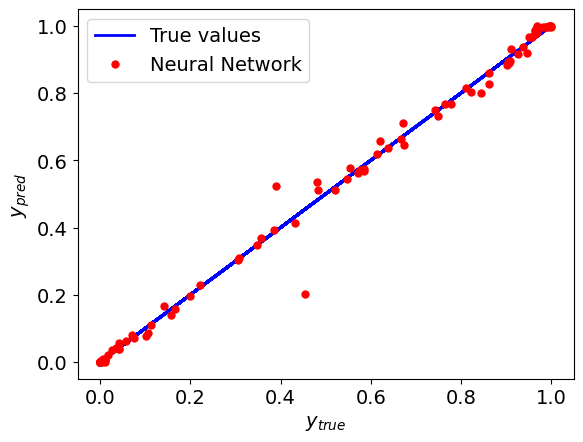

In [15]:
model=models.load_model(network_name_multiinput)
print(network_name_multiinput)
model.summary()
score = model.evaluate([x_val[:,:3],x_val[:,-1]], y_val, verbose=1)

# Check validation dataset with N random values
N=100
range_rnd=np.random.randint(0,len(x_val),size=(1,N))
y_pred=model.predict([x_val[range_rnd[0],:3],x_val[range_rnd[0],-1]])
y_true=y_val.iloc[range_rnd[0]]

# Plot true vs predicted
plt.plot(y_true,y_true, color="blue", fillstyle='none',linewidth=2, marker='.', markersize=0,label='True values')
plt.plot(y_true,y_pred, color="red", linewidth=0, marker='.', markersize=10,label='Neural Network')
plt.xlabel('$y_{true}$')
plt.ylabel('$y_{pred}$')
plt.legend()
plt.show()

## Visualize spectra: neural network prediction against true values

index: 46
10/10 [==============================] - 0s 2ms/step
Parameters =
 [[ 80.001      485.71464286 223.67416327 400.001     ]]


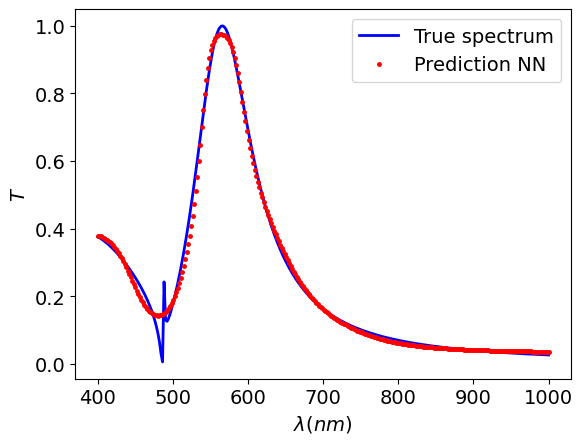

In [18]:
# Number of wavelengths for spectrum
nwav=300

# Data as pandas dataframes
train_data, test_data = train_test_split(SCATTnorm, test_size=0.8, shuffle = False)

# Convert to numpy arrays
train_data=np.array(train_data)
test_data=np.array(test_data)

# Test data
x_test = test_data[:, :4]  # get the first 4 columns
y_test = test_data[:, -1]  # get the last 2 columns

# Random picked spectrum in test
j=np.random.randint(int(x_test.shape[0]/300)) #j-esima wavelength
print('index:',j)

# Wavelengths
wavelengths=x_test[j*nwav:(j+1)*nwav,3]

# Convert to numpy arrays
nn_pred=model.predict([x_test[j*nwav:(j+1)*nwav,:3],x_test[j*nwav:(j+1)*nwav,-1]])

# Print the geometrical parameters (normalized)
max_lambda = SCATT.iloc[:, 3].max()
wavelengths=wavelengths*max_lambda
parameters=max_lambda*x_test[j*nwav:(j+1)*nwav, :]
print("Parameters =\n",parameters[0:1])

# Scattering
scatt_true=y_test[j*nwav:(j+1)*nwav]
scatt_pred=nn_pred

# Plot
plt.plot(wavelengths,scatt_true, color="blue", fillstyle='none',linewidth=2, marker='.', markersize=0,label='True spectrum')
plt.plot(wavelengths,scatt_pred, color="red", linewidth=0, marker='.', markersize=5,label='Prediction NN')
plt.xlabel('$\lambda (nm)$')
plt.ylabel('$T$')
plt.legend()
plt.show()

# Appendix: Modal Expansion Method

Next, the ME implementation used in this work, applied to perfectly conducting Hole Arrays, is briefly discribed. Maxwell's equations are solved by expanding the EM fields in the different regions of space, transmission and reflection coefficients are thus calculated by imposing appropriate boundary conditions.  The metal is chosen to be a PEC ($\vert \varepsilon_{metal} \vert = \infty$), which is a good approximation in the THz regime for geometrical features much larger than the skin depth.

The whole space is divided in three regions: (I) the substrate, (II) holes and, (III) the superstrate. In region (I) the EM field is expanded in terms of TE and TM waveguide eigenmodes. However, good convergence is attained only by considering the less decaying transversal electric mode, $TE_{0,1}$ for subwavelength rectangular holes (the fundamental waveguide mode). Within this minimal model, results can be worked out analytically.  The in-plane electric field component of the $TE_{0,1}$ mode is defined as:

\begin{equation}
 \vec {E}^{TE}_{\vert \vert}(r_{\vert \vert})=\sqrt{\frac{2}{a_x a_y}} \left(sin[q_y(y+a_y/2)],0\right)
\end{equation}
within the interval $\vec{r}_{\vert \vert} \in [-a_y/2,a_y/2]\times[-a_x/2,a_x/2]$ and zero otherwise, where $q_y=\pi/a_y$ is the only component of its parallel wave vector, being the corresponding propagation constant $q_z=\sqrt{\varepsilon_{II} g^2-q_y^2}$,  with $g=2\pi/\lambda$ ($\varepsilon_{II}=\varepsilon_{\text{hole}}$).

In the substrate ($\varepsilon_{I}=\varepsilon_{\text{substrate}}$) and the superstrate ($\varepsilon_{III}=\varepsilon_{\text{superstrate}}$) the EM fields are expressed in terms of plane waves,
characterized by the in-plane component of the wave-vector ${\vec{k}_{\vert \vert}}=(k_x,k_y)$ and, satisfying the $z$-component the isotropic dispersion relation $k_z=\sqrt{\varepsilon_{I,III} g^2-k_{\vert \vert}^2}$, $k_{\vert \vert}^2=k_x^2+k_y^2$.

By matching the EM fields at the interfaces, we end up with a set of two coupled linear equations where the electric field amplitude of the fundamental mode at the input side, $E$, [$\vec {e} (z=-h)=E\, \vec {E}^{TE}_{\vert \vert}(r_{\vert \vert})$], and at the output side, $E'$, [$\vec {e'}(z=0)=-E'\, \vec{E}^{TE}_{\vert \vert}(r_{\vert \vert})$], are unknowns:

\begin{eqnarray}
(G^I-\Sigma)\; E \;-\;G_v \;E'&=&I_0 \nonumber \\
(G^{III}-\Sigma)\; E'\; -\;G_v\; E &=&0
\end{eqnarray}

These equations lead to the solution:
\begin{eqnarray}
E &=& \frac{I_0 (G^{III}-\Sigma)}{(G^+-\Sigma)^2-G_v^2-(G^-)^2}
\nonumber
\\ E' &=& \frac{I_0 G_v}{(G^+-\Sigma)^2-G_v^2-(G^-)^2}
\end{eqnarray}
, here $G^\pm=[G^{I}(\lambda,\varepsilon_I) \pm G^{III}(\lambda,\varepsilon_{III})]/2$.

The different terms in these equations have a simple physical interpretation. The EM-coupling between the input and the output side of the holes to the continuum of plane waves is mediated by the Green's functions $G^I(\lambda,\varepsilon_I)$ and $G^{III}(\lambda,\varepsilon_{III})$, respectively. The general expression for these functions can be expressed as $G^{I}=\imath\sum_{\vec{k}\, \sigma}Y_{\vec{k} \, \sigma}^I|S_{{\vec{k}},\sigma}|^2$, where $\sigma$ stands for the polarization ($\sigma=p$ or $\sigma=s$). Here, $Y_{\vec{k} \, s}^I=k_z/g$ and $Y_{\vec{k} \, p}^I=\varepsilon_I g/k_z$ (and the same for $G^{III}$ with $\varepsilon_{III}$). Note that the ${\vec{k}}$-vector runs over the reciprocal lattice vectors, that is, for a rectangular lattice $k_x=\frac{2\pi}{p_x} \, n$ and $k_y=\frac{2\pi}{p_y} \, m$ ($n$ and $m$ being integer numbers). Usually a few difracction orders are enough to obtain converged results. On the other hand, the coupling between the fundamental mode and free-space modes comes from overlap integrals  which depend upon the specific hole shape, in our case:

\begin{equation}
S_{{\vec{k}},\sigma}=\int{ dr_{\vert \vert}\vec{V}_{\sigma} \cdot \vec{E}^{TE}_{\vert \vert} (r_{\vert \vert}) \frac{e^{\imath \vec{k}_{\vert \vert} \cdot \vec{r}_{\vert \vert}}}{\sqrt{p_x p_y}}}
\end{equation}
, where $\vec{V}_{p}=(k_x,k_y)/k_{\vert \vert}$ and $\vec{V}_{s}=(-k_y,k_x)/k_{\vert \vert}$ for $k_{\vert \vert} \neq 0$. For for $k_{\vert \vert} = 0$, $\vec{V}_{p}=(1,0)$ and $\vec{V}_{s}=(0,1)$
, so for rectangular holes:
\begin{eqnarray}
S_{{\vec{k}},\sigma} &=& \frac{\sqrt{a_x a_y}}{\sqrt{2 p_x p_y}} \, f_{{\vec
k},\sigma}sinc[k_xa_x/2] \cdot \nonumber \\
\cdot &\,&(sinc[\frac{(k_y+q_y)a_y}{2}]+sinc[\frac{(k_y-q_y)a_y}{2}])
\end{eqnarray}
where $sinc[x]= \sin[x]/x$ and $f_{{\vec{k}},p}=k_x/k_{\vert \vert}$, $f_{{\vec{k}},s}=-k_y/k_{\vert \vert}$, for $k_{\vert \vert}\neq 0$. For $k_{\vert \vert} = 0$, $f_{{\vec{k}},p}=1$ and $f_{{\vec{k}},s}=0$.

The real part of these Green's functions ($G_r$) controls the
matching between the fundamental waveguide mode and the evanescent
EM modes in vacuum, and so does the imaginary part ($G_i$) with the
propagating modes.

The term $I_0$ measures the overlap between the
incident plane wave and the fundamental mode inside the hole:
\begin{equation}
%I_0=2\imath \, \frac{q_z}{g}|S_{{\vec{k}_0},\sigma_0}|^2
I_0=2\imath \, Y_{{{\vec{k}_0},\sigma_0}}^I S_{{\vec{k}_0},\sigma_0}
\end{equation}
The term $G_v$ controls the EM coupling between the input and the output sides of the holes:
\begin{equation}
G_v=2\imath\,\frac{q_z}{g}\frac{e^{iq_zh}}{e^{2iq_zh}-1}
\end{equation}
Finally, the expression for $\Sigma$ is given by:
\begin{equation}
\Sigma=\imath \frac{q_z}{g}\,\frac{e^{2iq_zh}+1} {e^{2iq_zh}-1}
\end{equation}
To obtain the transmittance $T$ at normal incidence, within the minimal model approximations, we have to impose  ${\vec{k}_0}=(0,0)$ and $\sigma=p$. Transmittance finally reads:
\begin{equation}
T=G^{III}_i\vert E' \vert^2/\sqrt\varepsilon_I
\end{equation}
, and reflectance:
\begin{equation}
R=1-2Re\left[ S_{{\vec{k}_0},\sigma_0} \, E \right] + G^{I}_i\vert E \vert^2/\sqrt\varepsilon_I
\end{equation}